In [34]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [35]:
df = pd.read_csv('cycle_data.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])
df.head()

,HIGH_T,LOW_T,PRECIP,BB_COUNT
Date,,,,
2017-04-01,46.0,37.0,0.00,606
2017-04-02,62.1,41.0,0.00,2021
2017-04-03,63.0,50.0,0.03,2470
2017-04-04,51.1,46.0,1.18,723
2017-04-05,63.0,46.0,0.00,2807


In [36]:
ds = df.index.to_series()
df['MONTH'] = ds.dt.month
df['DAY_OF_WEEK'] = ds.dt.dayofweek
df['DAY'] = ds.dt.day
df.head()

,HIGH_T,LOW_T,PRECIP,BB_COUNT,MONTH,DAY_OF_WEEK,DAY
Date,,,,,,,
2017-04-01,46.0,37.0,0.00,606,4,5,1
2017-04-02,62.1,41.0,0.00,2021,4,6,2
2017-04-03,63.0,50.0,0.03,2470,4,0,3
2017-04-04,51.1,46.0,1.18,723,4,1,4
2017-04-05,63.0,46.0,0.00,2807,4,2,5


In [37]:
#Create the training and testing data sets.
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]

#Setup the regression expression in patsy notation. We are telling patsy that BB_COUNT is our dependent variable and
# it depends on the regression variables: DAY, DAY_OF_WEEK, MONTH, HIGH_T, LOW_T and PRECIP.
expr = """BB_COUNT ~ DAY  + DAY_OF_WEEK + MONTH + HIGH_T + LOW_T + PRECIP"""

#Set up the X and y matrices
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')


In [41]:
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
poisson_training_results

In [30]:
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               BB_COUNT   No. Observations:                  170
Model:                            GLM   Df Residuals:                      163
Model Family:                 Poisson   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11611.
Date:                Thu, 26 Dec 2019   Deviance:                       21585.
Time:                        11:46:59   Pearson chi2:                 2.13e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.9854      0.012    565.274      

In [31]:
poisson_predictions = poisson_training_results.get_prediction(X_test)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

                   mean    mean_se  mean_ci_lower  mean_ci_upper
Date                                                            
2017-04-04   818.855585   7.682382     803.935985     834.052067
2017-04-06  1114.270688   7.452921    1099.758562    1128.974313
2017-04-10  3257.515840  14.176508    3229.848559    3285.420122
2017-04-14  2534.972333   8.630173    2518.113812    2551.943719
2017-04-16  3236.439441  15.551191    3206.102742    3267.063191
2017-04-18  2808.927714  10.523618    2788.377345    2829.629539
2017-04-25  1034.568810   7.907698    1019.185523    1050.184287
2017-04-27  2430.102395   8.841943    2412.834151    2447.494225
2017-05-17  3991.848871  18.733806    3955.299636    4028.735841
2017-05-18  3523.271764  12.814600    3498.244919    3548.477653
2017-06-02  2699.553212   8.233862    2683.463280    2715.739620
2017-06-05  2515.969435  10.188158    2496.080045    2536.017308
2017-06-15  2649.155396   6.406130    2636.629319    2661.740982
2017-06-24  1069.912522  

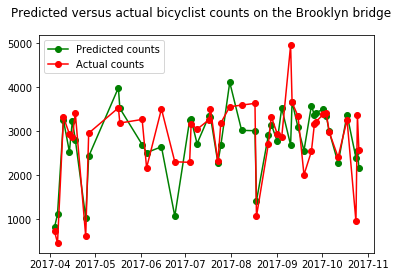

In [32]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['BB_COUNT']
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()


<Figure size 432x288 with 0 Axes>

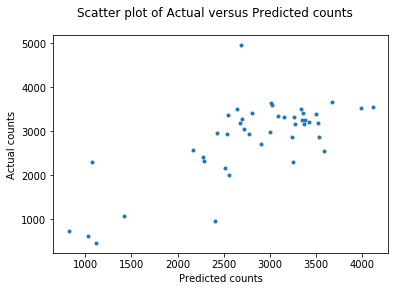

In [33]:
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()